# Plant Disease Data EDA

In [1]:
import os
import sys
import time
import re
import datetime as dt

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, PReLU
from keras.optimizers import SGD, RMSprop, Adam
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.preprocessing import image
from keras import regularizers

import numpy as np
import pandas as pd
import seaborn as sns
import tqdm

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

sns.set_palette('muted',color_codes=True)
sns.set_context('notebook', font_scale=1.4)
vc_color = '#B5C9EB'

Using TensorFlow backend.


In [2]:
# Path variables
data_dir = "../data/raw/plant_diseases/color/original/"

# Get list of all classes
classes = os.listdir(data_dir)
set(classes)

{'Apple___apple_scab',
 'Apple___black_rot',
 'Apple___cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry___healthy',
 'Cherry___powdery_mildew',
 'Corn___common_rust',
 'Corn___gray_leaf_spot',
 'Corn___healthy',
 'Corn___northern_leaf_blight',
 'Grape___black_measels',
 'Grape___black_rot',
 'Grape___healthy',
 'Grape___leaf_blight',
 'Orange___citrus_greening',
 'Peach___bacterial_spot',
 'Peach___healthy',
 'Pepperbell___bacterial_spot',
 'Pepperbell___healthy',
 'Potato___early_blight',
 'Potato___healthy',
 'Potato___late_blight',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___powdery_mildew',
 'Strawberry___healthy',
 'Strawberry___leaf_scorch',
 'Tomato___bacterial_spot',
 'Tomato___early_blight',
 'Tomato___healthy',
 'Tomato___late_blight',
 'Tomato___leaf_mold',
 'Tomato___leaf_spot',
 'Tomato___mosaic_virus',
 'Tomato___spider_mites',
 'Tomato___target_spot',
 'Tomato___yellow_leaf_curl_virus'}

In [3]:
# List of species
species = set()
for c in classes:
    s = re.findall(".+?___", c)[0][:-3]
    species.add(s)
species

{'Apple',
 'Blueberry',
 'Cherry',
 'Corn',
 'Grape',
 'Orange',
 'Peach',
 'Pepperbell',
 'Potato',
 'Raspberry',
 'Soybean',
 'Squash',
 'Strawberry',
 'Tomato'}

In [4]:
# List of diseases
diseases = set()
for c in classes:
    d = re.findall("___.+", c)[0][3:]
    diseases.add(d)
diseases

{'apple_scab',
 'bacterial_spot',
 'black_measels',
 'black_rot',
 'cedar_apple_rust',
 'citrus_greening',
 'common_rust',
 'early_blight',
 'gray_leaf_spot',
 'healthy',
 'late_blight',
 'leaf_blight',
 'leaf_mold',
 'leaf_scorch',
 'leaf_spot',
 'mosaic_virus',
 'northern_leaf_blight',
 'powdery_mildew',
 'spider_mites',
 'target_spot',
 'yellow_leaf_curl_virus'}

In [5]:
# Look at specie, disease combinations
combined = []
for d in diseases:
    for s in species:
        name = s + "___" + d
        if name in classes:
            out = (d, s, 1)
        else:
            out = (d, s, 0)
        combined.append(out)
combined = pd.DataFrame(combined)
combined.columns = ['disease', 'specie', 'flag']
combined.pivot_table(values='flag', index='disease', columns='specie')

specie                  Apple  Blueberry  Cherry  Corn  Grape  Orange  Peach  \
disease                                                                        
apple_scab                  1          0       0     0      0       0      0   
bacterial_spot              0          0       0     0      0       0      1   
black_measels               0          0       0     0      1       0      0   
black_rot                   1          0       0     0      1       0      0   
cedar_apple_rust            1          0       0     0      0       0      0   
citrus_greening             0          0       0     0      0       1      0   
common_rust                 0          0       0     1      0       0      0   
early_blight                0          0       0     0      0       0      0   
gray_leaf_spot              0          0       0     1      0       0      0   
healthy                     1          1       1     1      1       0      1   
late_blight                 0          0       0     0      0       0      0   
leaf_blight                 0          0       0     0      1       0      0   
leaf_mold                   0          0       0     0      0       0      0   
leaf_scorch                 0          0       0     0      0       0      0   
leaf_spot                   0          0       0     0      0       0      0   
mosaic_virus                0          0       0     0      0       0      0   
northern_leaf_blight        0          0       0     1      0       0      0   
powdery_mildew              0          0       1     0      0       0      0   
spider_mites                0          0       0     0      0       0      0   
target_spot                 0          0       0     0      0       0      0   
yellow_leaf_curl_virus      0          0       0     0      0       0      0   

specie                  Pepperbell  Potato  Raspberry  Soybean  Squash  \
disease                                                                  
apple_scab                       0       0          0        0       0   
bacterial_spot                   1       0          0        0       0   
black_measels                    0       0          0        0       0   
black_rot                        0       0          0        0       0   
cedar_apple_rust                 0       0          0        0       0   
citrus_greening                  0       0          0        0       0   
common_rust                      0       0          0        0       0   
early_blight                     0       1          0        0       0   
gray_leaf_spot                   0       0          0        0       0   
healthy                          1       1          1        1       0   
late_blight                      0       1          0        0       0   
leaf_blight                      0       0          0        0       0   
leaf_mold                        0       0          0        0       0   
leaf_scorch                      0       0          0        0       0   
leaf_spot                        0       0          0        0       0   
mosaic_virus                     0       0          0        0       0   
northern_leaf_blight             0       0          0        0       0   
powdery_mildew                   0       0          0        0       1   
spider_mites                     0       0          0        0       0   
target_spot                      0       0          0        0       0   
yellow_leaf_curl_virus           0       0          0        0       0   

specie                  Strawberry  Tomato  
disease                                     
apple_scab                       0       0  
bacterial_spot                   0       1  
black_measels                    0       0  
black_rot                        0       0  
cedar_apple_rust                 0       0  
citrus_greening                  0       0  
common_rust                      0       0  
early_blight                     0       1  
gray_l

In [6]:
# Number of images in each class
image_counts = {}
for c in classes:
    path = data_dir + c
    count = len(os.listdir(path))
    image_counts[c] = count
pd.DataFrame.from_dict(image_counts, orient='index')

0
Apple___apple_scab                631
Apple___black_rot                 622
Apple___cedar_apple_rust          276
Apple___healthy                  1646
Blueberry___healthy              1503
Cherry___healthy                  855
Cherry___powdery_mildew          1053
Corn___common_rust               1193
Corn___gray_leaf_spot             514
Corn___healthy                   1163
Corn___northern_leaf_blight       986
Grape___black_measels            1384
Grape___black_rot                1181
Grape___healthy                   424
Grape___leaf_blight              1077
Orange___citrus_greening         5508
Peach___bacterial_spot           2298
Peach___healthy                   361
Pepperbell___bacterial_spot       998
Pepperbell___healthy             1479
Potato___early_blight            1001
Potato___healthy                  153
Potato___late_blight             1001
Raspberry___healthy               372
Soybean___healthy                5091
Squash___powdery_mildew          1836
Strawberry___healthy              457
Strawberry___leaf_scorch         1110
Tomato___bacterial_spot          2128
Tomato___early_blight            1001
Tomato___healthy                 1592
Tomato___late_blight             1910
Tomato___leaf_mold                953
Tomato___leaf_spot               1772
Tomato___mosaic_virus             374
Tomato___spider_mites            1677
Tomato___target_spot             1405
Tomato___yellow_leaf_curl_virus  5358

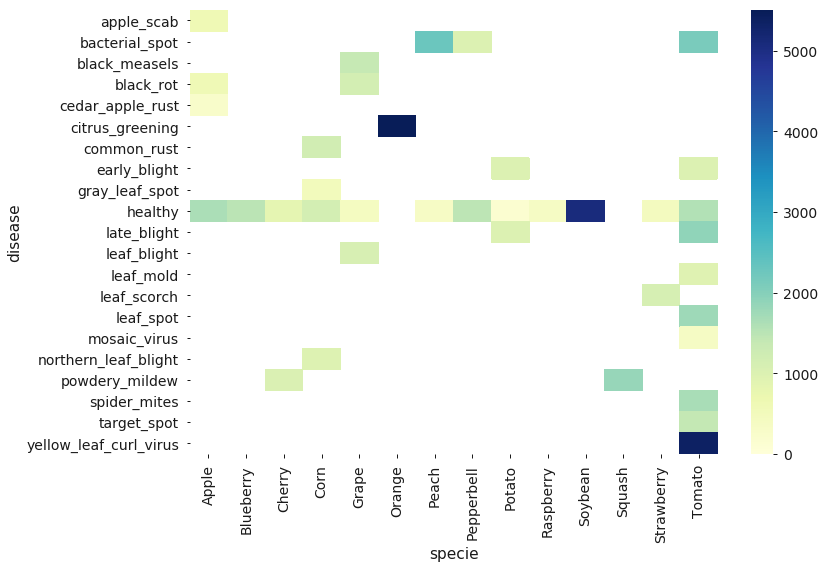

In [7]:
# Look at specie, disease combinations
combined = []
for d in diseases:
    for s in species:
        name = s + "___" + d
        if name in classes:
            path = data_dir + name
            count = len(os.listdir(path))
            out = (d, s, count)
        else:
            out = (d, s, 0)
        combined.append(out)
combined = pd.DataFrame(combined)
combined.columns = ['disease', 'specie', 'flag']
hm = combined.pivot_table(values='flag', index='disease', columns='specie')

plt.figure(figsize=(12, 8))
msk = hm == 0
sns.heatmap(hm, cmap="YlGnBu", mask=msk);
plt.tight_layout()
plt.savefig("./images/specie_disease_heatmap.png")

In [8]:
print(f"Total number of images: {sum(image_counts.values())}")

Total number of images: 54343


In [9]:
# Get path and label for each training image
db=[]
for label, class_name in enumerate(classes):
    path = data_dir + class_name
    for file in os.listdir(path):
        if not '.ini' in file:
            db.append(['{}/{}'.format(class_name, file), label, class_name])
db = pd.DataFrame(db, columns=['file', 'label', 'class_name'])

In [10]:
def read_img(filepath, size):
    img = image.load_img(data_dir + filepath, target_size=size)
    img = image.img_to_array(img)
    return img

def format_name(s):
    return re.sub('_+', ' ', s)

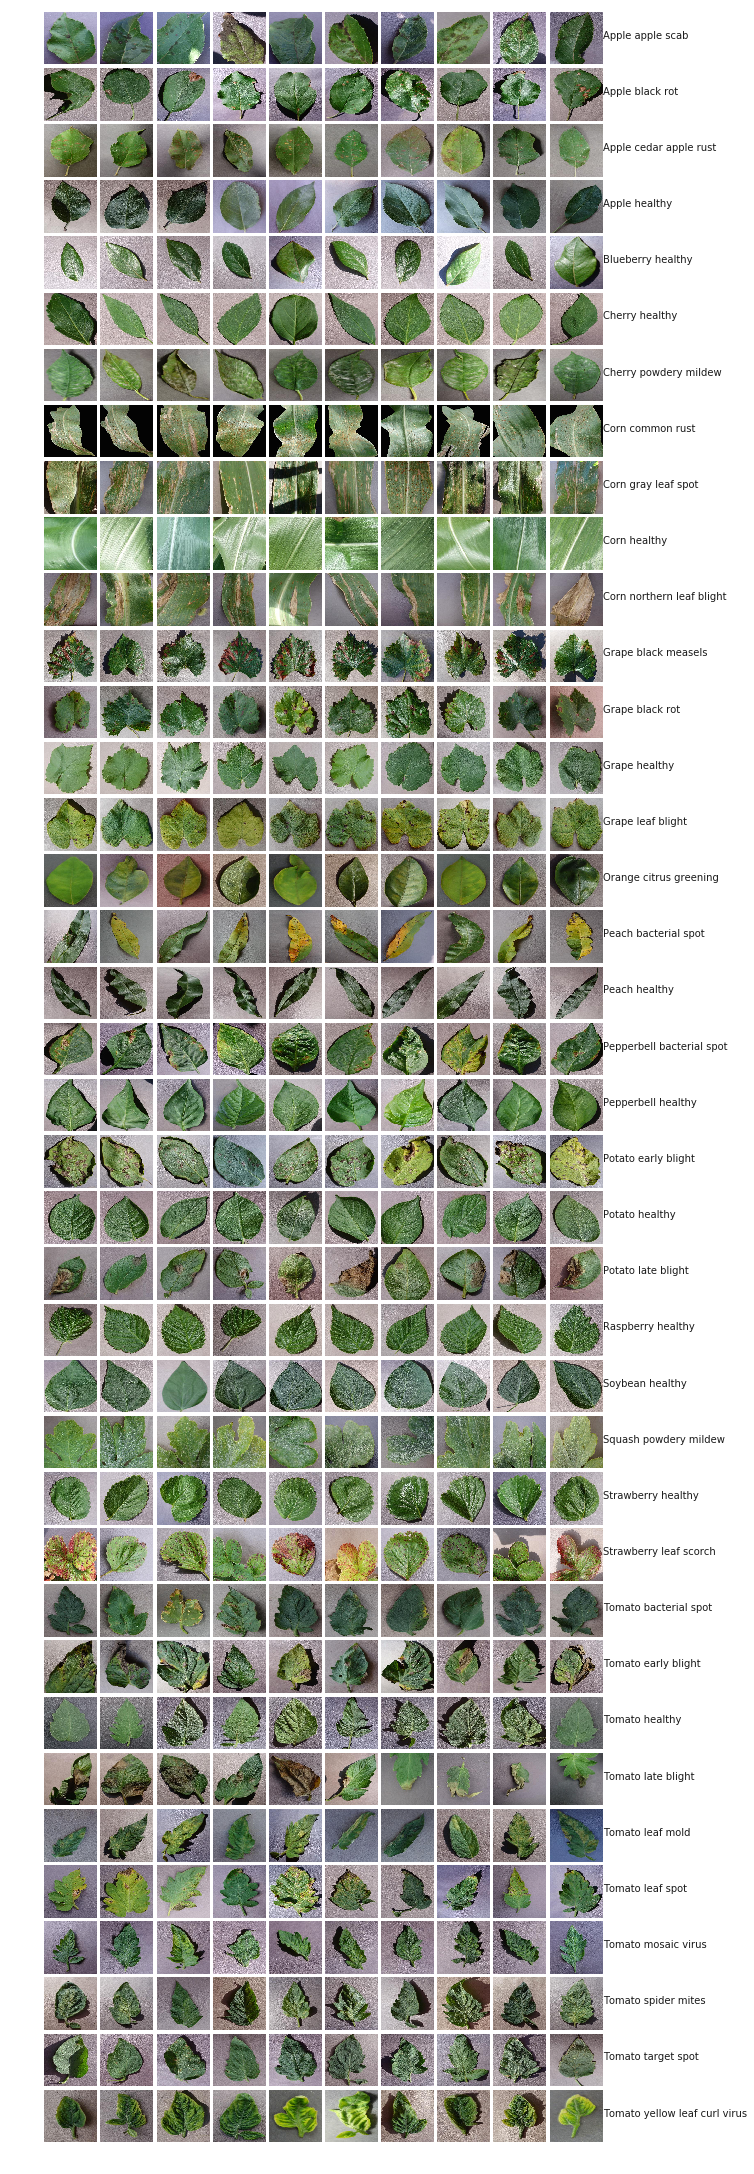

In [11]:
# Plot some images (fixed dimensions)
num_classes = len(classes)
fig = plt.figure(1, figsize=(10, 40))
grid = ImageGrid(fig, 111, nrows_ncols=(num_classes, 10), axes_pad=0.05)

i = 0
for label, class_name in enumerate(classes):
    for filepath in db[db['class_name'] == class_name]['file'].values[:10]:
        ax = grid[i]
        img = read_img(filepath, (256, 256))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % 10 == 10 - 1:
            name = format_name(filepath.split('/')[0])
            ax.text(260, 112, name , verticalalignment='center')
        i += 1
        
plt.show();

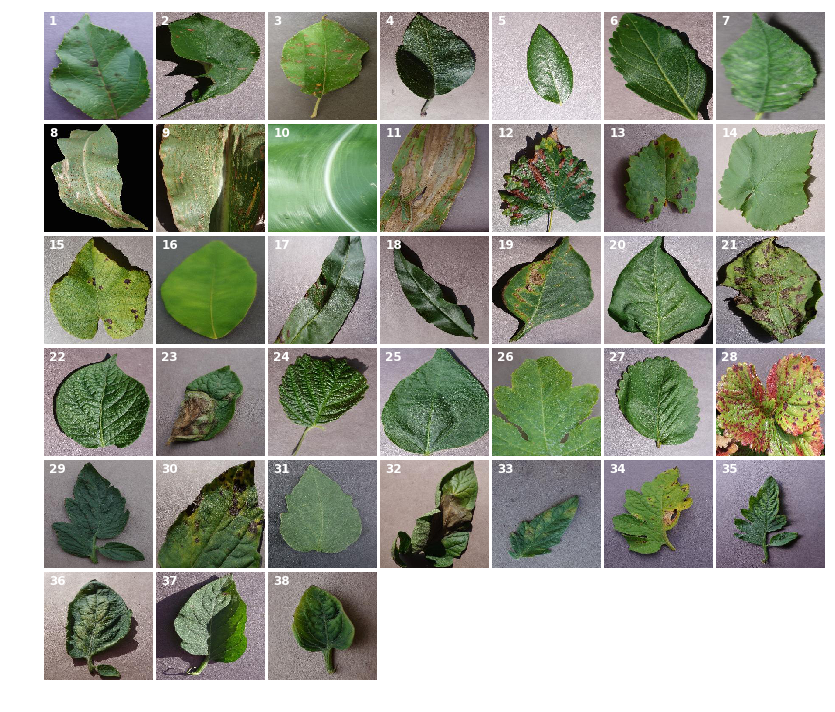

In [12]:
# Plot image from each class
fig = plt.figure(1, figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 7), axes_pad=0.05)

for i in range(42):
    ax = grid[i]
    ax.axis('off')
    if i < len(classes):
        class_name = classes[i]
        for filepath in db[db['class_name'] == class_name]['file'].values[:1]:
            img = read_img(filepath, (224, 224))
            ax.imshow(img / 255.)
            ax.annotate(i+1, xy=(10,25), color="white", fontsize=12, fontweight='bold')
plt.tight_layout();
plt.savefig("./images/image_per_specie.png")

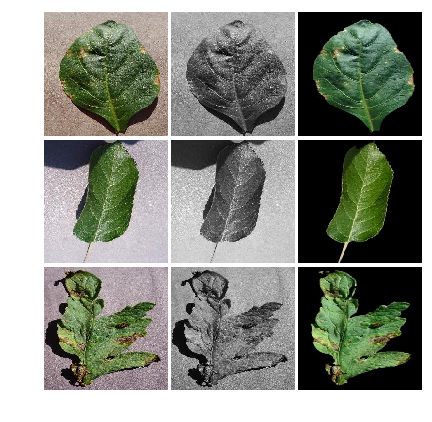

In [13]:
data_dir = "../data/raw/plant_diseases/"

fig = plt.figure(1, figsize=(6, 6))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 3), axes_pad=0.05)

np.random.seed(33)
rnd = np.random.randint(0, len(db), 3)
image_types = ["color", "grayscale", "segmented"]
i = 0
for r in rnd:
    file = db.file[r]
    for t in image_types:
        filepath = data_dir + t + "/original/" + file
        if t == "segmented":
            filepath = filepath.replace(".JPG", "") + "_final_masked.JPG"
            
        ax = grid[i]
        img = image.load_img(filepath, target_size=(256, 256))
        img = image.img_to_array(img)
        ax.imshow(img / 255.)
        ax.axis('off')
        i += 1
plt.tight_layout()
plt.savefig("./images/image_types.png")